# Dynet tutorial: Visualizing the Barnsley fern fractal

This time we're visualizing another fractal: the Barnley leaf. This one takes a bit more work and will introduce new operations (affine transformation) as well as a trick to sample one hot vectors according to a specific distribution *in the computation graph* (which is useful later-on if you want to do scheduled sampling in language modesl for instance).

The Barnsley fern $\mathcal F\subset\mathbb R^2$ can be defined recursively with:

\begin{split}
(0,0)&\in\mathcal F\\
\forall i\in\{1,2,3,4\}&,x\in\mathcal F\\ f_i(x)&\in\mathcal F\\
\end{split}
Where $f_1,f_2,f_3,f_4$ four affine transformations (functions of the form $x\longrightarrow Ax+b$, $A\in \mathbb R^{2\times 2}$, $b\in\mathbb R^2$. Using adequate $f_i$ transforms, this results in a cool looking "self similar" fractal.

In general it is impossible to draw $\mathcal F$ exactly because it contains infinitely many point. However by iterating from $(0,0)$ with a random transformation $f_i, i\in\{1,2,3,4\}$, we can represent a subset of the figure. It turns out that by choosing good probabilities for each transformation we get a pretty representative figure (the points are "uniformly" distributed). Again, you can read more in the [wikipedia entry](https://en.wikipedia.org/wiki/Barnsley_fern). Let's get started.

Import all the things we need. This code uses the latest master at the time of writing but it should work with releases >=2.0.3

In [1]:
import numpy as np
import dynet as dy
# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

The next thing we need is to define (manually) the parameters for the 4 affine transforms as well as the probability distribution from which we'll sample each transformation. I took the values straight from Wikipedia.

For convenience, I'll store these parameters in a `dy.ParameterCollection`.

In [49]:
# Create parameter collection
pc = dy.ParameterCollection()
# Lists storing the parameter matrices and biases
A, b = [], []
# f1(x)=A1x + b1
# Declare the values as numpy arrays
A1=np.asarray([[0.00, 0.00],
               [0.00, 0.16]])
b1=np.asarray([0.00, 0.00])
# Add them to the parameter collection (and keep track of the created parameters)
A.append(pc.add_parameters((2,2), init=A1))
b.append(pc.add_parameters(2, init=b1))
# f2=A2x + b2
A2=np.asarray([[ 0.85, 0.04],
               [-0.04, 0.85]])
b2=np.asarray([0.00, 1.60])
A.append(pc.add_parameters((2,2), init=A2))
b.append(pc.add_parameters(2, init=b2))
# f3=A3x + b3
A3=np.asarray([[0.20, -0.26],
               [0.23,  0.22]])
b3=np.asarray([0.00, 1.60])
A.append(pc.add_parameters((2,2), init=A3))
b.append(pc.add_parameters(2, init=b3))
# f4=A4x + b4
A4=np.asarray([[-0.15, 0.28],
               [0.26,  0.24]])
b4=np.asarray([0.00, 0.44])
A.append(pc.add_parameters((2,2), init=A4))
b.append(pc.add_parameters(2, init=b4))
# Probabilities
p_vals = np.asarray([0.01, 0.85, 0.07, 0.07])
p = pc.add_parameters(4, init=p_vals)

In [24]:
def f(i, x):
    A_i = dy.inputTensor(A[i])
    b_i = dy.inputTensor(b[i])
    return dy.affine_transform([b_i, A_i, x])

In [29]:
def sample_1_hot(prob, batch_size):
    log_prob = dy.inputTensor(np.log(prob))
    log_prob_noise = log_prob + dy.random_gumbel(len(p), batch_size=batch_size)
    one_hot = dy.argmax(log_prob_noise, 'zero_gradient')
    return one_hot
    

We then define the hyper-parameters for our experiment (number of iterations, etc...)

In [50]:
# Number of trajectories
N = 100000
# Number of iterations (length of the trajectories)
n_iterations = 20

We're ready to start the iterative process. Remember that we're still following the sacrosanct procedure
1. Call `dy.renew_cg()` to garbage-collect the computation graph
2. Add inputs to the computation graph with `dy.inputTensor`
3. Write all our operations (builds the computation graph)
4. Run the forward pass by calling `.npvalue()` on the output (all the computation is done here)
5. ~~Run the backward pass~~ N/A here, we're not computing gradients
6. ~~call `trainer.update()`~~ N/A here, we're not optimizing anything
7. Rinse and repeat

In this specific case step 3. will be a bit more complicated than in previous tutorials.

In [44]:
# Every trajectory has the same starting point (0,0).
# Recall that in dynet, the batch dimension (here N) should be the last dimension when using `inputTensor`
x_vals = [np.zeros((2, N))]
# Let's get started
for iteration in range(n_iterations):
    # Renew the computation graph
    dy.renew_cg()
    # Input the current points in the computation graph as a batch of 2d vectors
    x = dy.inputTensor(x_vals[-1], batched=True)
    # Compute all possible xs
    next_xs = [dy.affine_transform([b_i, A_i, x])
               for i in range(4)]
    rand_idx = sample_1_hot(p, N)
    next_x = dy.concatenate_cols(next_xs) * rand_idx
    next_x_vals = next_x.npvalue()
    x_vals.append(next_x_vals)
        

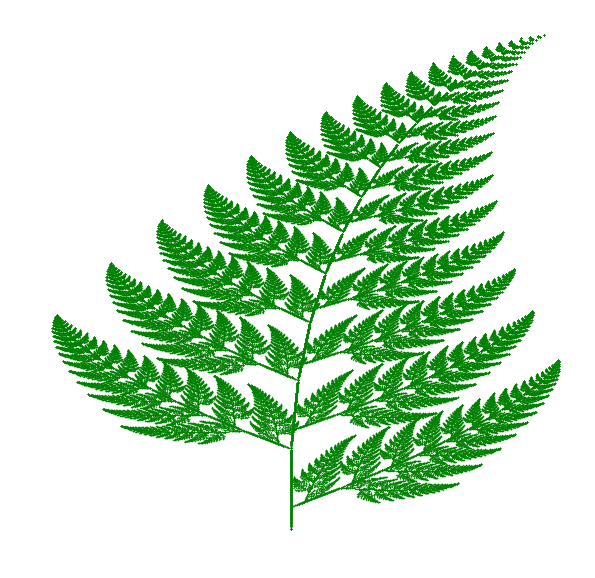

In [47]:
points = np.concatenate(x_vals, axis=-1)
plt.figure(figsize=(10,10))
plt.scatter(points[0], points[1], s=0.05, c='green')
_ = plt.axis('off')